In [5]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import array
import heapq

**Import data**

In [6]:
name="MultilayerLSTM32"
documents = []
for file in os.listdir("reuters_sample/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("reuters_sample", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')

        ## get all 'topic'
        # topics = {topic.name for topic in soup.find_all()}
  
        ## iterate all 'topic'
        # for topic in topics:
          
        ## find all element of 'topic'
          # for i in soup.find_all('topic'):
  
        ## if tag has attribute of class
            # if i.has_attr('trade'):
  
# We have selected the following 20 'TOPICS' out of 135:
# that we want to use for our prediction exercise: 1.) "trade" 2.) "earn" 3.) "grain" 4.) "money-fx" 5.) 
# "coffee" 6.) "gold" 7.) "acq" 8.) "wheat" 9.) "veg-oil" 10.) "nat-gas" 11.) "cooper" 12.) "ship" 13.) 
# "dlr" 14.) "crude" 15.) "interest" 16.) "meal-feed" 17.) "alum" 18.) "money-supply" 19.) "cocoa" 20.) "livestock"
        contents = soup.findAll('title')
        
        for content in contents:
            documents.append(content.text)

In [7]:
print('Number of documents: {}'.format(len(documents)))

Number of documents: 6966


In [8]:
# Remove duplicated strings from the list of strings
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]

print('Number of documents: {}'.format(len(documents)))

Number of documents: 6731


In [9]:
documents[:10]

['bahia cocoa review',
 'standard oil <srd> to form financial unit',
 'texas commerce bancshares <tcb> files plan',
 'talking point/bankamerica <bac> equity offer',
 'national average prices for farmer-owned reserve',
 'argentine 1986/87 grain/oilseed registrations',
 'red lion inns files plans offering',
 "usx <x> debt dowgraded by moody's",
 'champion products <ch> approves stock split',
 'computer terminal systems <cpml> completes sale']

**Join the documents**

In [10]:
data = ""
for d in documents:
    data += d

In [11]:
print('Number of data: {}'.format(len(data)))

Number of data: 302870


In [12]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 302335
bahia cocoa reviewstandard oil <srd> to form financial unittexas commerce bancshares <tcb> files pla


In [13]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
data = data.translate(translator)
print(data[:100])

bahia cocoa reviewstandard oil  srd  to form financial unittexas commerce bancshares  tcb  files pla


In [14]:
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

44856


[3302, 513, 3303, 29, 1457]

In [15]:
# determine the vocabulary size
# unique_words = tokenizer.word_index
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 13007


**Next, we need to create sequences of words to fit the model with one word as input and one word as output.**

In [16]:
# create word -> word sequences
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[513, 3303, 29, 1457, 1]
558


In [17]:
print('Total Sequences: %d' % len(prev_words))

Total Sequences: 44850


In [18]:
# list(len(prev_words)[:5]) # [input, output]



**We can then split the sequences into input (X) and output elements (y)**



In [19]:
# split into X and y elements
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)

# X = np.zeros((len(prev_words), WORD_LENGTH, vocab_size), dtype=bool)
# Y = np.zeros((len(next_words), vocab_size), dtype=bool)

In [20]:
print(X[:5])
print(Y[:5])

[[ 513 3303   29 1457    1]
 [3303   29 1457    1  558]
 [  29 1457    1  558   98]
 [1457    1  558   98 1458]
 [   1  558   98 1458  559]]
[ 558   98 1458  559  822]


In [21]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X.shape
Y.shape

(44850, 13007)

**Build the model**

In [23]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=5)) # original: 5
model.add(LSTM(32, return_sequences=True, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

2023-02-25 11:32:44.105177: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-25 11:32:44.114558: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 11:32:44.114614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bishal-pc): /proc/driver/nvidia/version does not exist
2023-02-25 11:32:44.136797: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 5)              65035     
                                                                 
 lstm (LSTM)                 (None, 5, 32)             4864      
                                                                 
 lstm_1 (LSTM)               (None, 5, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 13007)             429231    
                                                                 
Total params: 515,770
Trainable params: 515,770
Non-trainable params: 0
_________________________________________________________________
None


**Train the model**

In [24]:
# fit network
optimizer = RMSprop(learning_rate=0.01)

# compile network
#### since labels are INTEGERS, we need to changed from loss='categorical_crossentropy'!!!
#### If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer ='adam'
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history


2023-02-25 11:32:46.490041: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2216756996 exceeds 10% of free system memory.


Epoch 1/20
333/333 [==============================] - 20s 41ms/step - loss: 8.3823 - accuracy: 0.0261 - val_loss: 8.4059 - val_accuracy: 0.0285
Epoch 2/20
333/333 [==============================] - 13s 38ms/step - loss: 7.8808 - accuracy: 0.0292 - val_loss: 8.6151 - val_accuracy: 0.0285
Epoch 3/20
333/333 [==============================] - 13s 38ms/step - loss: 7.8052 - accuracy: 0.0292 - val_loss: 8.7667 - val_accuracy: 0.0285
Epoch 4/20
333/333 [==============================] - 13s 38ms/step - loss: 7.7527 - accuracy: 0.0292 - val_loss: 8.9130 - val_accuracy: 0.0285
Epoch 5/20
333/333 [==============================] - 13s 38ms/step - loss: 7.7075 - accuracy: 0.0291 - val_loss: 9.0650 - val_accuracy: 0.0281
Epoch 6/20
333/333 [==============================] - 13s 38ms/step - loss: 7.6558 - accuracy: 0.0339 - val_loss: 9.0911 - val_accuracy: 0.0267
Epoch 7/20
333/333 [==============================] - 13s 38ms/step - loss: 7.6008 - accuracy: 0.0350 - val_loss: 8.9912 - val_accuracy:

**Save trained model**

In [25]:
# After successful training, we will save the trained model and just load it back as needed.
model.save('keras_next_word_model'+str(name)+'.h5')
pickle.dump(history, open('history'+str(name)+'.p', 'wb'))

**Prediction**
Using saved model:
- we input the sample as a feature vector
- we convert the input string to a single feature vector

**Creating a Prediction script**

In [26]:
import matplotlib.pyplot as plt
import matplotlib


In [28]:
#Loading back the saved weights and history

model = load_model('keras_next_word_model'+str(name)+'.h5')
history = pickle.load(open('history'+str(name)+'.p', 'rb'))

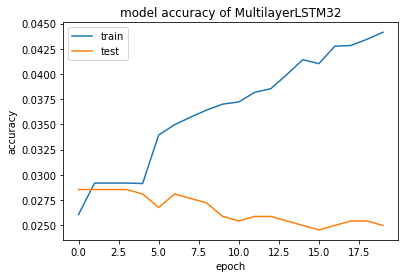

In [29]:
#Evaluation
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy of '+str(name))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("01.Accuracy"+str(name)+".png")

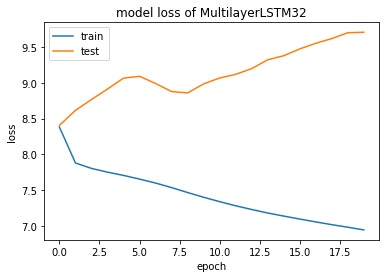

In [30]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss of ' +str(name))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc= 'upper left')

plt.savefig("02.Loss"+str(name)+".png")

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [35]:
max_sequence_len=6
seed_text = "farmers concerned about british sugar"
next_words = 2
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    #predicted = model.predict_classes(token_list, verbose=0)
    predict_x=model.predict(token_list) 
    predicted=np.argmax(predict_x,axis=1)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

1/1 [==============================] - 0s 23ms/step
farmers concerned about british sugar test ohio
